# Hyperparameters

In [1]:
batch_size = 256
learning_rate = 0.001
epochs = 120
CHECKPOINT_PATH = "/kaggle/working/vgg19_bn.pt"

# Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import copy
import os

In [3]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# Data Augmentation

In [4]:
train_transform = transforms.Compose([
    # Data Augmenatatin
    transforms.RandomAutocontrast(p=0.5),
    transforms.ColorJitter(saturation=0.2, brightness=0.2),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Dataset

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=val_transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

100%|██████████| 170498071/170498071 [00:04<00:00, 35289095.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Show image in train & val

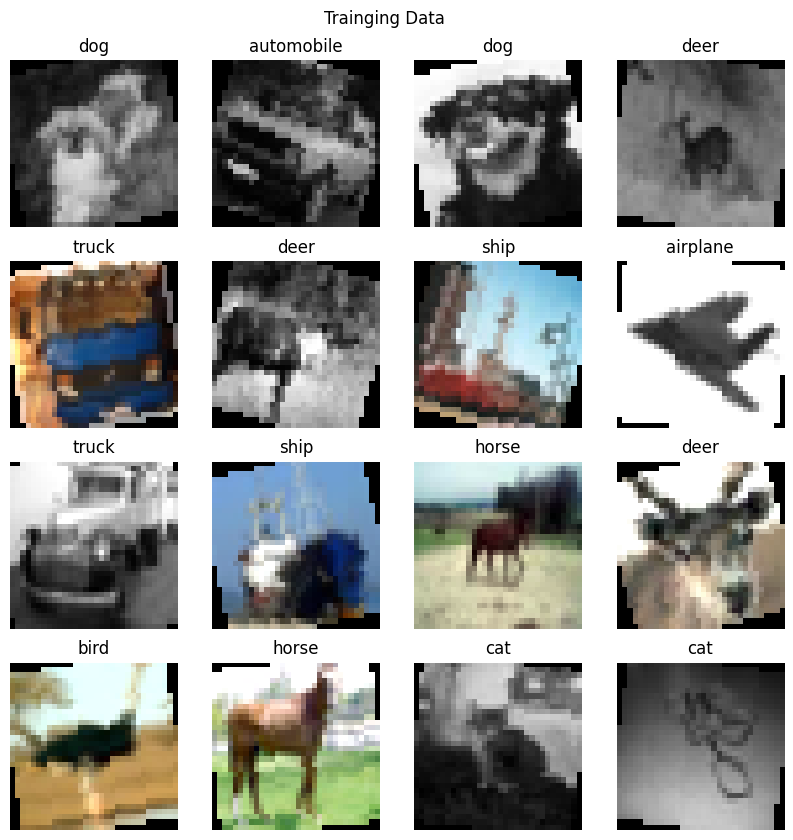

In [6]:
data_iterator = iter(train_loader)

inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = classes[labels[i]]
    plt.title(title)
    
    plt.axis('off')
plt.suptitle(f'Trainging Data', y=0.93)

plt.show()

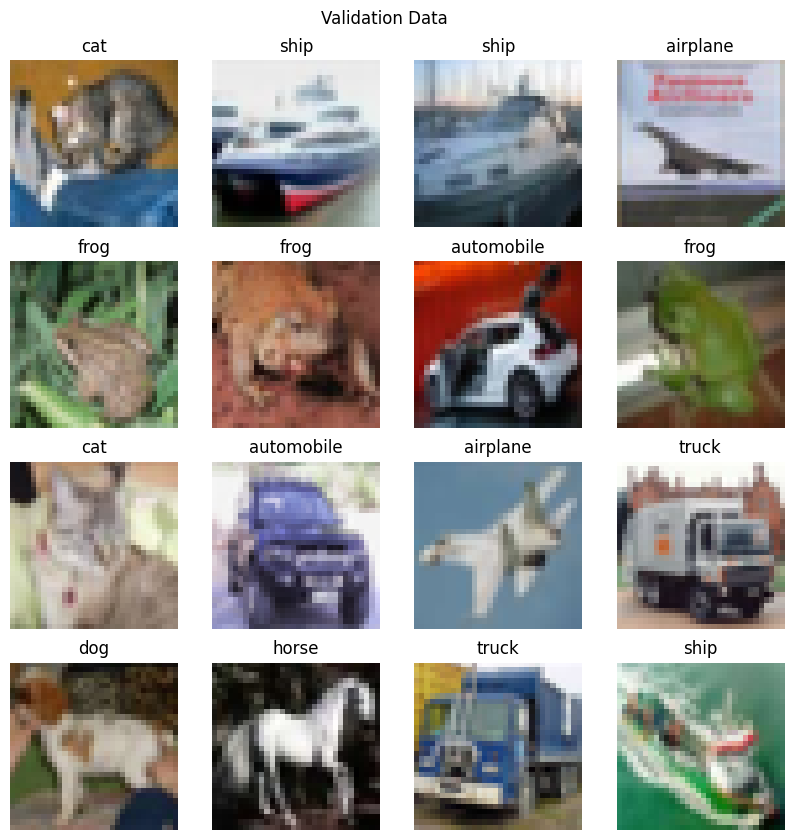

In [7]:
data_iterator = iter(val_loader)

inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = classes[labels[i]]
    plt.title(title)
    
    plt.axis('off')
plt.suptitle(f'Validation Data', y=0.93)

plt.show()

# Define model

In [8]:
from torchvision import models

model = models.vgg19_bn(num_classes=10)


model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Define optimizer

In [9]:
def Optimizer(model,learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), learning_rate,momentum=0.9)
    return criterion,optimizer

# Define train

In [10]:
def train (model,epochs,learing_rate):
    
    trainLoss = []
    valLoss = []
    trainAcc = []
    valAcc = []
    criterion,optimizer = Optimizer(model,learing_rate)
    # Best Model acc
    best_acc = 0.0

    # Train epochs rounds
    for epoch in range(epochs): 

        # train_epoch_loss
        train_epoch_loss = 0.0 

        # train class correct & class total of each mini_patch
        train_class_correct = list(0. for i in range(10))
        train_class_total = list(0. for i in range(10))

        # Run all train dataset
        for i, data in enumerate(train_loader, 0):
        
            # One batch data
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear optimizer graident
            optimizer.zero_grad()
            # Model output of each batch from train_dataset
            outputs = model(inputs)

            # Compute Loss & Update loss
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()
            optimizer.step()
            
            # 1. Compute train_batch_loss
            train_epoch_loss += batch_loss.item() 

            # 2. Compute train_class_correct of each batch
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                train_class_correct[label] += batch_correct[j].item()
                train_class_total[label] += 1
            
        # Compute Loss & Acc & F1Score of training
        train_epoch_loss = train_epoch_loss / len(train_loader)
        train_epoch_accurncy = sum(train_class_correct) / sum(train_class_total) * 100
        print('[Epoch:%2d]' % (epoch + 1))
        print('Train Accuracy of All : %.3f %%' % (train_epoch_accurncy))
        print('Train Loss of All : %.3f ' % (train_epoch_loss))
        print("----------------------------------------")
        trainLoss.append(train_epoch_loss)
        trainAcc.append(train_epoch_accurncy)
        # Reset metrics of training
        train_epoch_loss = 0.0 
        train_class_correct = list(0. for i in range(10))
        train_class_total = list(0. for i in range(10))

        # Validation class correct & class total
        val_class_correct = list(0. for i in range(10))
        val_class_total = list(0. for i in range(10))
        val_loss = 0.0

        # Validation every epoch
        validation = val_loader
        with torch.no_grad():
            # Run all Validation dataset
            for data in validation:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                # Model output of each batch from Validation_dataset
                outputs = model(images)

                # 1. Compute val_batch_loss
                batch_loss = criterion(outputs, labels)
                val_loss += batch_loss.item()
                
                # 2. Compute val_class_correct of each batch
                _, predicted = torch.max(outputs, 1)
                batch_correct = (predicted == labels).squeeze()
                for j in range(len(labels)):
                    label = labels[j]
                    val_class_correct[label] += batch_correct[j].item()
                    val_class_total[label] += 1
        # print each class accurancy of  Validation
        for i in range(10):
            label = classes[i]
            print('Accuracy of %5s : %2d %%' % (label, 100 * val_class_correct[i] / val_class_total[i]))
        # Compute Loss & Acc & F1Score of Validation 
        val_accurncy = sum(val_class_correct) / sum(val_class_total) * 100
        val_loss = val_loss / len(validation)

        print('Validation Accuracy of All : %.3f %%' % (val_accurncy))
        print('Validation Loss of All : %.3f ' % (val_loss))
        print("----------------------------------------")
        valLoss.append(val_loss)
        valAcc.append(val_accurncy)

        # Save checkpoint every epoch
        torch.save(model.state_dict(), "/kaggle/working/vgg19_bn.pth")
        # Save best model
        if val_accurncy > best_acc:
            best_acc = val_accurncy
            torch.save(model.state_dict(), "/kaggle/working/best.pth")
    print('Finished Training')
    return trainAcc,valAcc,trainLoss,valLoss


# Start train

In [11]:
trainAcc,valAcc,trainLoss,valLoss = train(model,epochs,learning_rate)

[Epoch: 1]
Train Accuracy of All : 22.358 %
Train Loss of All : 2.072 
----------------------------------------
Accuracy of airplane : 37 %
Accuracy of automobile : 62 %
Accuracy of  bird : 19 %
Accuracy of   cat :  8 %
Accuracy of  deer : 22 %
Accuracy of   dog : 41 %
Accuracy of  frog : 49 %
Accuracy of horse : 42 %
Accuracy of  ship : 53 %
Accuracy of truck : 26 %
Validation Accuracy of All : 36.300 %
Validation Loss of All : 1.680 
----------------------------------------
[Epoch: 2]
Train Accuracy of All : 38.106 %
Train Loss of All : 1.666 
----------------------------------------
Accuracy of airplane : 58 %
Accuracy of automobile : 55 %
Accuracy of  bird : 14 %
Accuracy of   cat : 30 %
Accuracy of  deer : 35 %
Accuracy of   dog : 40 %
Accuracy of  frog : 58 %
Accuracy of horse : 60 %
Accuracy of  ship : 51 %
Accuracy of truck : 54 %
Validation Accuracy of All : 46.070 %
Validation Loss of All : 1.456 
----------------------------------------
[Epoch: 3]
Train Accuracy of All : 45.

# Show result

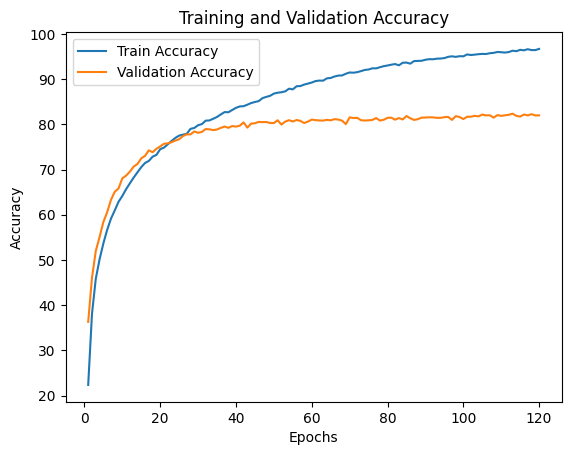

In [13]:
epochs = list(range(1, 121))

plt.plot(epochs, trainAcc, label='Train Accuracy', linestyle='-')

plt.plot(epochs, valAcc, label='Validation Accuracy', linestyle='-')

plt.legend()

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('accuracy_plot.png')
plt.show()


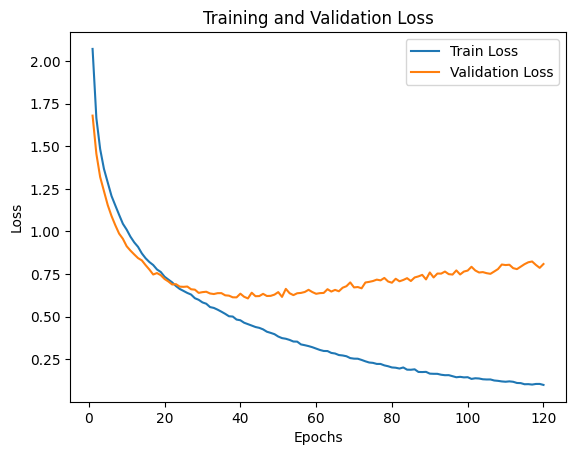

In [14]:
epochs = list(range(1, 121))

plt.plot(epochs, trainLoss, label='Train Loss', linestyle='-')

plt.plot(epochs, valLoss, label='Validation Loss', linestyle='-')

plt.legend()

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss_plot.png')
plt.show()

In [15]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('vgg19_bn.pth')

/kaggle/working


/kaggle/working/vgg19_bn.pth